In [70]:
# %load ./scripts/do_RT_thermal.py
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
import sys
#sys.path.append('../')
import models as wedge

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

pi = np.pi
au2m = 1.496e+11

In [85]:
def _scalarfieldWriter(model, data=None, fname=''):
    """Writes a scalar field to a file.

        Parameters
        ----------

        data   : ndarray
                Scalar variable to be written

        fname  : str
                Name of the file containing a scalar variable

        """
    nx,ny,nz = model.m.grid['N']
    with open(fname, 'w') as wfile:
        if len(data.shape) == 3:
            hdr = np.array([1, nx * ny * nz], dtype=int)
            hdr.tofile(wfile, sep=" ", format="%d\n")
            #need fortran indexing
            data = data.ravel(order='F')
            data.tofile(wfile, sep=" ", format="%.9e\n")

        elif len(data.shape) == 4:
            hdr = np.array([1, nx * ny * nz, data.shape[3]], dtype=int)
            hdr.tofile(wfile, sep=" ", format="%d\n")
            #need fortran indexing
            data = data.ravel(order='F')
            data.tofile(wfile, sep=" ", format="%.9e\n")
        else:
            raise ValueError('Incorrect shape. Data stored in a regular grid should have 3 or 4 dimensions'
                                         + ' with the fourth dimension being the dust species. '
                                         + ' The data to be written has a dimension of ' + ("%d" % len(data.shape))
                                         + '\n No data has been written')
            
            
##### for line transfer ##########################################################
def write_lines(model,names=['co']):
    """ writes the lines.inp file for radmc3d in leiden format
    Parameters
    ---------
    model: model class object, model.outdir stores where to write the file

    names: list of str, names of molecules to include in line transfer
    """
    with open(model.outdir+'lines.inp','w+') as f:
        f.write('2\n')                   # Format number
        f.write('{}\n'.format(len(names)))             # Number of molecules
        for name in names:
            f.write('{} leiden 0 0 0\n'.format(name))
    return True

def write_velocities(model,envelope = True):
    """ writes the gas_velocity.inp file for radmc3d
    Parameters
    ----------
    model: model class object, model.outdir stores where to write the file

    envlope: boolean, if True, envelope is included in the calculation of the velocity field,
                      if False, disk only
    """
    if envelope == True:
        velocities = model.v_embedded()
    else:
        velocities = model.v_disk()
    Nr = np.prod(np.array(model.grid['N']))
    print('writing gas_velocity.inp')
    with open(model.outdir+'gas_velocity.inp','w+') as f:
        f.write('1\n')                   # Format number
        f.write('%d\n'%(Nr))             # Number of cells
        vr = velocities['r'].swapaxes(0,1).ravel(order='F')
        vth = velocities['theta'].swapaxes(0,1).ravel(order='F')
        vphi = velocities['phi'].swapaxes(0,1).ravel(order='F')
        for i,j,k in zip(vr,vth,vphi):
            f.write("%9e %9e %9e\n" % (i, j, k))
    return

In [2]:
s18 = {'Ms': 0.8, 'Rs': 2.0, 'Ts': 5000, 'accrate':1e-7,'f':0.01, 'Mdisk': 0.003, 'Mfrac': [0.0001,0.00999],'R0':[0.1,0.1], 'H0':[1,0.3], 'p':[-1,-1], 'Rdisk':[200,200],'Min': 0, 'Rc':300, 'rho_amb':1e-25, 'rho_0': 3e-22,'theta_min':45,'exf':0.25,'Rmax':5e3, 'd2g': 0.01, 'shock':False,'N':[250,90,48], 'min':[0.1,pi/32.,0], 'max':[2500,pi/2.,2*pi], 'spacing':['log','lin','lin'],'rho_si':3.1518, 'amin_chem':0.06, 'amax_ism': 1.0, 'amin': [0.005,0.005], 'amax': [1,1e3], 'apow': [3.5,3.5],'cr_model': 'ssx','zetacr': 1.3e-17, 'LX': 1e30, 'G0':1, 'viscous_heating':False}

m1 = initialize_model(s18,outdir='out/schwarz18/')

NameError: name 'initialize_model' is not defined

In [2]:
outdir='out/schwarz18/'
m1 = wedge.load_model(outdir)
m1.m.print_params()

directory exists - will overwrite current model if you write to it!
Loading from model directory:/Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/wavelength_micron.inp
stellar_params: {'Ms': 0.8, 'Rs': 2.0, 'Ts': 5000, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.003, 'Mfrac': [0.0001, 0.00999], 'R0': [0.1, 0.1], 'H0': [1, 0.3], 'p': [-1, -1], 'Rdisk': [200, 200], 'Tfac': 1, 'q': 0.5, 'hydro': [None, None, None]}
envelope_params: {'Min': 0, 'Rc': 300, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 45, 'exf': 0.25, 'Rmax': 5000.0, 'd2g': 0.01, 'shock': False, 'nstreams': 1, 'stream_frac': 1}
grid_params: {'N': [250, 90, 48], 'min': [0.1, 0.09817477042468103, 0], 'max': [2500, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': [3.5, 3.5]}
RT_params: {'cr_model': 'ssx

In [3]:
filename_small_dust = 'sm_maps_std'
filename_large_dust = 'lg_maps_std'

wedge.write_opacities(m1.m,ndust=2,filenames=[filename_small_dust,filename_large_dust],update=True)

fname sm_maps_std
/Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/dustkappa_sm_maps_std.inp: user dust opacity file found in model directory
Updating x-ray opacities
fname lg_maps_std
/Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/dustkappa_lg_maps_std.inp: user dust opacity file found in model directory
Updating x-ray opacities
updating dustopac.inp


In [4]:
wedge.prep_thermal_transfer(m1)
wedge.do_thermal_transfer(m1,nt=8)

Reading /Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/wavelength_micron.inp
Writing /Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/wavelength_micron.inp
Writing stars.inp
updating radmc3d.inp
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow t

 Thread:           0 Photon nr:                79000
 Thread:           5 Photon nr:                80000
 Thread:           5 Photon nr:                81000
 Thread:           4 Photon nr:                82000
 Thread:           5 Photon nr:                83000
 Thread:           7 Photon nr:                84000
 Thread:           6 Photon nr:                85000
 Thread:           4 Photon nr:                86000
 Thread:           4 Photon nr:                87000
 Thread:           3 Photon nr:                88000
 Thread:           0 Photon nr:                89000
 Thread:           2 Photon nr:                90000
 Thread:           2 Photon nr:                91000
 Thread:           7 Photon nr:                92000
 Thread:           7 Photon nr:                93000
 Thread:           2 Photon nr:                94000
 Thread:           1 Photon nr:                95000
 Thread:           7 Photon nr:                96000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               237000
 Thread:           7 Photon nr:               238000
 Thread:           7 Photon nr:               239000
 Thread:           7 Photon nr:               240000
 Thread:           3 Photon nr:               241000
 Thread:           4 Photon nr:               242000
 Thread:           0 Photon nr:               243000
 Thread:           0 Photon nr:               244000
 Thread:           4 Photon nr:               245000
 Thread:           1 Photon nr:               246000
 Thread:           7 Photon nr:               247000
 Thread:           0 Photon nr:               248000
 Thread:           6 Photon nr:               249000
 Thread:           7 Photon nr:               250000
 Thread:           1 Photon nr:               251000
 Thread:           5 Photon nr:               252000
 Thread:           1 Photon nr:               253000
 Thread:           6 Photon nr:               254000
 Thread:           7 Photon nr:               

 Thread:           1 Photon nr:               399000
 Thread:           7 Photon nr:               400000
 Thread:           1 Photon nr:               401000
 Thread:           7 Photon nr:               402000
 Thread:           1 Photon nr:               403000
 Thread:           4 Photon nr:               404000
 Thread:           0 Photon nr:               405000
 Thread:           0 Photon nr:               406000
 Thread:           3 Photon nr:               407000
 Thread:           2 Photon nr:               408000
 Thread:           5 Photon nr:               409000
 Thread:           6 Photon nr:               410000
 Thread:           7 Photon nr:               411000
 Thread:           7 Photon nr:               412000
 Thread:           1 Photon nr:               413000
 Thread:           7 Photon nr:               414000
 Thread:           7 Photon nr:               415000
 Thread:           1 Photon nr:               416000
 Thread:           2 Photon nr:               

In [5]:
m1.read_rho()
m1.read_Tdust()
print('Temperature data is stored in m1.T with keys: ', m1.T.keys())
print('Density data is stored in m1.rho with keys:', m1.rho.keys())

Reading /Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/dust_density.inp
Reading /Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/dust_temperature.dat
Temperature data is stored in m1.T with keys:  dict_keys(['dust'])
Density data is stored in m1.rho with keys: dict_keys(['dust1', 'dust2', 'gas'])


In [52]:
print(m1.rho['gas'].shape)

mu = 2.36
mh = 1.67e-24 # mass of hydrogen cgs

#need number density of species as 1D array
X,Z = m1.make_rz() # in au

print(X.shape,Z.shape)


(250, 90, 48)
(90, 250) (90, 250)


In [53]:
nH2 = m1.rho['gas']/(2*mh)

In [205]:
#read in lime formatted file:
moddir = '/Users/schwarz/proposals/ALMA/Cycle11/ageproion/'
mod = 'D_0.003Mslg_0.99m_d200.0_Tgas_w98/'
flag = 'hi'
mol = 'DCO+'
outmol = 'dco+'
isofact = 1
time = '179'

filein = moddir+mod+mol+'_time'+time+'.dat'

lime = np.loadtxt(filein)
# R(m) Z(m) n_H2(number of H2 per m^3) Tgas(K) Tdust(K) abundance-relative-to-H2
lime.shape
inR = lime[:,0]/au2m # in au 
inZ = lime[:,1]/au2m

inabun = lime[:,-1]/isofact #check units for radmc3d

molabun = np.zeros_like(m1.rho['gas'])



#need to make abundance array in same order as 3d sphereical grid array
#molecule_field = (model.rho_embedded(fluid=0)/(mu*mh)) * X
#molecule_field = molecule_field.swapaxes(0,1)

#wedge.write_molecule_density(m1.m,molecules['names'],abundances=[nCO]) 



In [206]:
print(np.amin(inabun),np.amax(inabun))

0.0 2.656e-10


In [207]:
molabun.shape, nH2.shape

((250, 90, 48), (250, 90, 48))

In [208]:
xi = (X.flatten(),Z.flatten())

intrpabun = interpolate.griddata((inR,inZ),inabun,xi,method='linear',fill_value=0.0)

print(intrpabun.shape)
print(np.amin(intrpabun),np.amax(intrpabun))

intrpabun = intrpabun.reshape((90,250))

# i know there is a better way to do this
for phi in range(len(molabun[0,0,:])):
    molabun[:,:,phi] = intrpabun[:,:].swapaxes(0,1) * nH2[:,:,phi]

(22500,)
0.0 1.4584786714246514e-10


In [209]:
m1.m.outdir

'/Users/schwarz/Documents/GitHub/wedgeford/out/schwarz18/'

In [210]:
fname = m1.m.outdir+'numberdens_' + outmol + '.inp'
_scalarfieldWriter(m1,molabun, fname=fname)

In [211]:
#calc_gas_T(m1.m)
#for now just copying dust_temperature.dat into gas_temperature.dat

In [212]:
write_lines(m1.m,names=[outmol])
write_velocities(m1.m)

writing gas_velocity.inp


#got to get to here:
npix = 300
sizeau = 600
mol = 1
width = 6.0
nlam = 12
incl = 45.
pa = 0.0
command = 'radmc3d image iline 2 widthkms {} linenlam {} incl {} posang {} noscat doppcatch'.format(width,nlam,incl,pa)
os.system(command)

In [213]:
# iline specifies which transition in the leiden file you want to model 

In [214]:
command = 'radmc3d spectrum iline 4 widthkms 6.0 linenlam 40 incl 45 phi 30 noscat'
os.system(command)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

0

In [215]:

command = 'cp spectrum.out '+outmol+'_'+flag+'_specrtum.out'
os.system(command)

0

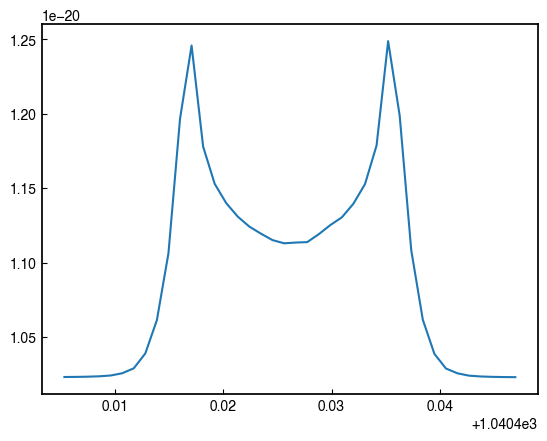

In [216]:
s = rpy.analyze.readSpectrum(fname=outmol+'_'+flag+'_specrtum.out') #flux in units of erg s-1 cm-2 Hz-1 at 1 pc
plt.plot(s[:,0],s[:,1])

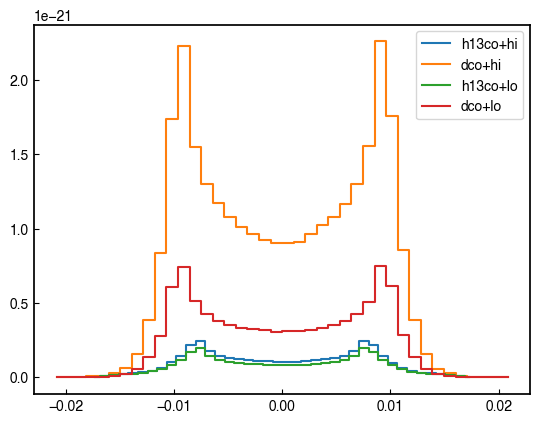

In [222]:
outmol = ['h13co+','dco+']
#cfreq = [219.5603541,346.9983381,288.143858]
flag = ['hi','lo']

for ii in flag:
    for m,mm in enumerate(outmol):
        s = rpy.analyze.readSpectrum(fname=mm+'_'+ii+'_specrtum.out')
        cfreq = np.mean(s[:,0])
        contlvl = np.amin(s[:,1])
        plt.plot(s[:,0]-cfreq,s[:,1]-contlvl,label=mm+ii,drawstyle='steps-mid')
        
plt.legend()

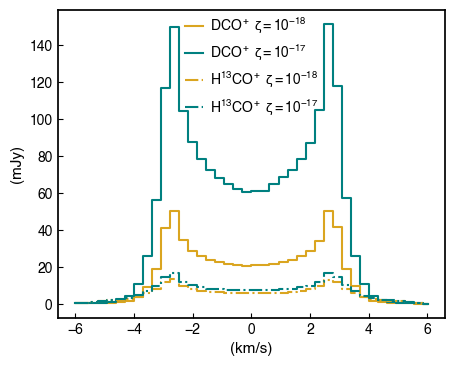

In [263]:
fig =plt.figure(figsize=(5., 4.))

outmol = ['dco+','h13co+']
#cfreq = [219.5603541,346.9983381,288.143858]
flag = ['lo','hi']

nice = [r'DCO$^+$',r'H$^{\mathrm{13}}$CO$^+$']
ion = [r' $\zeta=10^{-18}$',r' $\zeta=10^{-17}$']

clr = ['goldenrod','teal']

linsty = ['-','-.']


obsflux = 69. #mJy km/s for DCO+ in 2MASS J161-38

ref = 0

for m in range(len(outmol)):
    for ii in range(len(flag)):
        s = rpy.analyze.readSpectrum(fname=outmol[m]+'_'+flag[ii]+'_specrtum.out')
        cfreq = np.mean(s[:,0])
        contlvl = np.amin(s[:,1])
        totflux = np.trapz(s[:,1]-contlvl,s[:,0])
        if ref == 0:
            fac = obsflux/totflux/100
            ref = 1
        vel = 3e8*1e-3*(s[:,0]-cfreq)/cfreq
        #plt.plot(s[:,0]-cfreq,s[:,1]-contlvl,label=outmol[m]+ii,drawstyle='steps-mid')
        plt.plot(vel,fac*(s[:,1]-contlvl),label=nice[m]+ion[ii],drawstyle='steps-mid',c=clr[ii],linestyle=linsty[m])


plt.xlabel('(km/s)')
plt.ylabel('(mJy)')
plt.legend(handlelength=1.3,borderaxespad=0.0,handletextpad=0.5,frameon=False)
fig.savefig('/Users/schwarz/proposals/ALMA/Cycle11/ageproion/flux_H13CO+_DCO+_ion.png',format='png',dpi=300,bbox_inches='tight')

93.13000000000001